# Text Classification/Sentiment Analysis with BERT (Coronavirus tweets) - Natural Language Processing

In [2]:
# library
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [3]:
df_train = pd.read_csv('dataset/Corona_NLP_train.csv', encoding='latin-1')
df_test = pd.read_csv('dataset/Corona_NLP_test.csv', encoding='latin-1')

df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


# Preparing dataset - Basic Cleaning

In [8]:
# drop null value
df_train = df_train.dropna(axis=0, how='any')
df_test = df_test.dropna(axis=0, how='any')

In [9]:
# drop duplicates
df_train.drop_duplicates(inplace=True)

check the target/label, there are 5 classes

In [10]:
pd.unique(df_train['Sentiment'])

array(['Neutral', 'Positive', 'Negative', 'Extremely Positive',
       'Extremely Negative'], dtype=object)

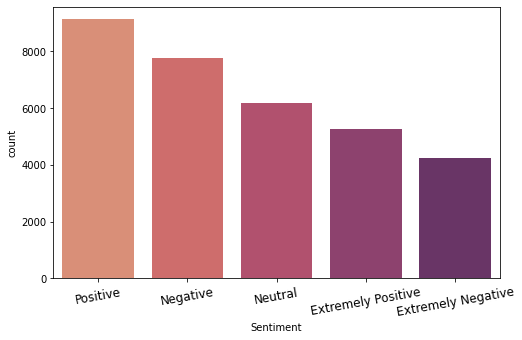

In [11]:
fig = plt.figure(figsize=(8,5))
fig.set_facecolor('white')
ax = sns.countplot(data=df_train, x='Sentiment', order=df_train['Sentiment'].value_counts().index, palette='flare')
ax.set_xticklabels(ax.get_xticklabels(), rotation=10, fontsize=12)
plt.show()

# Preparing dataset - General Text Cleaning (NLP)

we're only going to used 'OriginalTweet' as the feature/statement, and 'Sentiment' as the labels

In [12]:
df_train = df_train[['OriginalTweet','Sentiment']]
df_test = df_test[['OriginalTweet','Sentiment']]

In [13]:
import re, string
import emoji
import nltk

remove symbols, and other things that wont be used for word analysis (NLP Concept), such as:
- emoji
- hashtags
- symbols/special character
- extra spaces

In [14]:
def remove_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text)

In [15]:
def remove_hashtags(tweet):
    tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) 
    tweet = " ".join(word.strip() for word in re.split('#|_', tweet)) 
    return tweet

In [16]:
def remove_spaces(text): # remove spaces > 1
    return re.sub("\s\s+" , " ", text)

In [17]:
# remove $ and &
def remove_special_ch(sentences):
    cleaned = []
    for word in sentences.split(' '):
        if ('$' in word) | ('&' in word):
            cleaned.append('')
        else:
            cleaned.append(word)
    return ' '.join(cleaned)

lowercase and remove enter as well. (NLP concept)

In [18]:
def clean_general(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() # remove \n \r, lowercase
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii char
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) # remove https and @
    
    rmv = string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', rmv)
    text = text.translate(table)
    return text

run the cleaning function for both train and test 'OriginalTweet'

In [19]:
tweet_new = []

for tw in df_train['OriginalTweet']:
    tw = remove_emoji(tw)
    tw = clean_general(tw)
    tw = remove_hashtags(tw)
    tw = remove_special_ch(tw)
    tw = remove_spaces(tw)
    tweet_new.append(tw)

df_train['OriginalTweet'] = tweet_new

In [20]:
tweet_new = []

for tw in df_test['OriginalTweet']:
    tw = remove_emoji(tw)
    tw = clean_general(tw)
    tw = remove_hashtags(tw)
    tw = remove_special_ch(tw)
    tw = remove_spaces(tw)
    tweet_new.append(tw)

df_test['OriginalTweet'] = tweet_new

In [21]:
df_train.head()

,OriginalTweet,Sentiment
0,and and,Neutral
1,advice talk to your neighbours family to excha...,Positive
2,coronavirus australia woolworths to give elder...,Positive
5,as news of the regions first confirmed covid19...,Positive
6,cashier at grocery store was sharing his insig...,Positive


from the cleaned 'OriginalTweet' above, there are some tweet contain nothing such as on row o ('and and'), we can filter this using word count. here, i limit the word, where <10 will not be used

In [22]:
texts_len = []
for text in df_train['OriginalTweet']:
    text_len = len(text.split())
    texts_len.append(text_len)

df_train['text_len'] = texts_len

In [23]:
texts_len = []
for text in df_test['OriginalTweet']:
    text_len = len(text.split())
    texts_len.append(text_len)

df_test['text_len'] = texts_len

In [24]:
df_train = df_train[df_train['text_len'] >= 10]
df_test = df_test[df_test['text_len'] >= 10]

In [25]:
df_train = df_train[df_train['text_len'] <= 50]
df_test = df_test[df_test['text_len'] <= 50]

In [26]:
x_train = df_train['OriginalTweet'].values
y_train = df_train['Sentiment'].values
x_test = df_test['OriginalTweet'].values
y_test = df_test['Sentiment'].values

In [27]:
print(y_train)

['Positive' 'Positive' 'Positive' ... 'Positive' 'Neutral' 'Negative']


encode the labels to be inputed to the model, here i used one hot encoder, with 5 classes

In [28]:
from sklearn import preprocessing

In [29]:
# label encoding
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

# BERTokenizer

tokenize the sentences with BERTokenizer

In [30]:
#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
# from transformers import RobertaTokenizerFast
# from transformers import TFRobertaModel

In [31]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [33]:
def tokenize(df):
    input_id_list = []
    attention_mask_list = []

    for i in range(len(df)):
        tokenized = tokenizer.encode_plus(
            df[i],
            add_special_tokens = True,
            max_length = 100,
            padding='max_length',
            return_attention_mask = True
        )
        
        input_id_list.append(tokenized['input_ids'])
        attention_mask_list.append(tokenized['attention_mask'])
        # input_id_list.append(np.asarray(tokenized['input_ids']).astype(np.float32))
        # attention_mask_list.append(np.asarray(tokenized['attention_mask']).astype(np.float32))
    return np.array(input_id_list), np.array(attention_mask_list)

tokenize both train and test data, the output of the tokenized was input_id and attention_mask, which will be used as the input for our BERT Sequence Classifier

In [34]:
input_id_train, attention_mask_train = tokenize(x_train)
input_id_test, attention_mask_test = tokenize(x_test)

# BERT MODELING - BERTSequenceClassifier

make BERT model to classify multi-label class

In [35]:
import tensorflow as tf

In [36]:
print(tf. __version__)

2.8.0


In [37]:
from transformers import TFBertModel

In [38]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [39]:
def create_model(bert_model):
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-05, decay=1e-07)
    accuracy = tf.keras.metrics.CategoricalAccuracy()
    loss = tf.keras.losses.CategoricalCrossentropy()


    input_ids = tf.keras.Input(shape=(100,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(100,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    output = tf.keras.layers.Dense(5, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)    
    
    return model

In [40]:
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                           

on the model, i'm limmiting each features up to 100 word each due to computation limitation. I used input_id and attention_mask from the BERTokenizer earlier as the input

check the input and label size:

In [42]:
print(input_id_train.size)
print(attention_mask_train.size)
print(input_id_test.size)
print(attention_mask_test.size)
print(y_train.size)
print(y_test.size)

3058500
3058500
278500
278500
152925
13925


## Training the model

In [43]:
history_bert = model.fit([input_id_train, attention_mask_train], y_train, validation_data=([input_id_test, attention_mask_test], y_test), epochs=3, batch_size=32)

Epoch 1/3
956/956 [==============================] - 9762s 10s/step - loss: 1.0188 - categorical_accuracy: 0.5732 - val_loss: 0.7214 - val_categorical_accuracy: 0.7235
Epoch 2/3
956/956 [==============================] - 9982s 10s/step - loss: 0.6104 - categorical_accuracy: 0.7724 - val_loss: 0.6090 - val_categorical_accuracy: 0.7749
Epoch 3/3
956/956 [==============================] - 9940s 10s/step - loss: 0.4545 - categorical_accuracy: 0.8380 - val_loss: 0.5602 - val_categorical_accuracy: 0.8011


I used 3 epoch with 32 batch, which estimately runs for 130 min for each epoch, due to the long training time and computation limitation (I used my local PC to train), I only able to train 3 epoch, however the epoch can be increased to make better performed models.

# Result

performance analysis on testing dataset:

In [44]:
result_bert = model.predict([input_id_test,attention_mask_test])

In [45]:
y_pred =  np.zeros_like(result_bert)
y_pred[np.arange(len(y_pred)), result_bert.argmax(1)] = 1

In [46]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [47]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.87      0.82       425
           1       0.89      0.79      0.84       463
           2       0.76      0.77      0.77       774
           3       0.88      0.80      0.84       429
           4       0.76      0.80      0.78       694

   micro avg       0.80      0.80      0.80      2785
   macro avg       0.82      0.81      0.81      2785
weighted avg       0.81      0.80      0.80      2785
 samples avg       0.80      0.80      0.80      2785



In [48]:
confusion_matrix(y_test.argmax(1), y_pred.argmax(1))

array([[369,   0,  53,   2,   1],
       [  1, 366,   4,   0,  92],
       [ 94,   3, 596,  27,  54],
       [  2,   0,  53, 344,  30],
       [  4,  40,  78,  16, 556]], dtype=int64)

In [50]:
accuracy_score(y_test, y_pred)

0.8010771992818672